# Import Libraries

In [1]:
# install google translate library
!pip install googletrans==4.0.0-rc1

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from googletrans import Translator
from textblob import TextBlob
import re
import matplotlib.cm as cm
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings

import nltk
from nltk.stem.snowball import SnowballStemmer

# Import the necessary libraries
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\Lenovo\anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Loading the scraped Data

In [3]:
# Granulado
with open('data/granulado_mcbo.json') as file1:
    granulado = json.load(file1)

# Granulado's Competitors
with open('data/delisweets_mcbo.json') as file2:
    delisweets = json.load(file2)   
    
with open('data/brigadeirobombon.json') as file3:
    brigadeiro = json.load(file3)

In [47]:
accounts = [granulado, delisweets, brigadeiro]
profile_info = pd.DataFrame()
for account in accounts:
    # Extract the relevant account information
    account_data = {
        'username': account['username'],
        'website': account['website'],
        'name': account['name'],
        'ig_id': account['ig_id'],
        'id': account['id'],
        'profile_picture_url': account['profile_picture_url'],
        'biography': account['biography'],
        'follows_count': account['follows_count'],
        'followers_count': account['followers_count'],
        'media_count': account['media_count']
    }
    # Append the account information to the dataframe
    profile_info = profile_info.append(account_data, ignore_index=True)
    
# Display the profile information of every account
profile_info

,username,website,name,ig_id,id,profile_picture_url,biography,follows_count,followers_count,media_count
0,granulado_mcbo,http://wa.me/584246416641,By Hanan,38415715533,17841438505991964,https://scontent.fbey5-2.fna.fbcdn.net/v/t51.2...,Los mejores Brigadeiros Gourmet de la ciudad ❣...,384,4492,236
1,delisweets_mcbo,https://wa.me/+584146024444,Delisweets_mcbo,5329539481,17841405384436192,https://scontent.fbey5-1.fna.fbcdn.net/v/t51.2...,"""єи∂υℓzαи∂σ тυѕ мσмєитσѕ єѕρєςιαℓєѕ""\n Rᴇᴘᴏs...",3651,11591,1539
2,brigadeirobombon,https://wa.me/17867275707,BrigadeiroBombón,7519403786,17841407553589925,https://scontent.fbey5-2.fna.fbcdn.net/v/t51.2...,#brigadeirobombon,1335,2448,16


In [5]:
# transform the posts info of each JSON account to a dataframe
granulado_media = pd.json_normalize(granulado['media'])
delisweets_media = pd.json_normalize(delisweets['media'])
brigadeiro_media = pd.json_normalize(brigadeiro['media'])

In [6]:
# define a function that extracts important features from a dataframe
def extract_features(df):
    # Convert the "timestamp" column to pandas datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Date and Time Features
    df['Year'] = df['timestamp'].dt.year
    df['Month'] = df['timestamp'].dt.month
    df['Day of the Month'] = df['timestamp'].dt.day
    df['Day of the Week'] = df['timestamp'].dt.day_name()
    df['Time'] = df['timestamp'].dt.time
    df['Hour'] = df['timestamp'].dt.hour
    df['Part of the Day'] = df['timestamp'].dt.hour.apply(
        lambda x: 'Morning' if 5 <= x < 12 else 'Afternoon' if 12 <= x < 18 else 'Evening')
    df['Season'] = df['timestamp'].dt.month.apply(lambda month: 'Winter' if month in [1, 2] else
                  'Spring' if month in [3, 4, 5] else
                  'Summer' if month in [6, 7, 8] else
                  'Autumn' if month in [9, 10, 11] else
                  'Winter')
    # Total Engagement
    df['Total Engagements'] = df['like_count'] + df['comments_count']
    # Hashtag from the caption
    df['caption'] = df['caption'].astype(str)
    df['Hashtags'] = df['caption'].apply(lambda x: [re.sub(r'[^\w\s]', '', tag) for tag in re.findall(r'#(\w+)', x)])
    df['Hashtags'] = df['Hashtags'].apply(lambda x: [tag for tag in x if tag]) 
    return df

# define a function that cleans the caption before tranlating it to English
def clean_text(text):
    # change to lowercase
    text.lower()
    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove newline characters
    text = text.replace('\n', ' ')
    return text

# define a function to translate the caption from spanish to english
translator = Translator()
def translate_spanish_to_english(text):
    try:
        translated_text = translate_spanish_to_english(text)
        return translated_text
    except Exception as e:
        print(f"Error translating caption: {text}. Error: {str(e)}")
        return ''

In [7]:
granulado_media = extract_features(granulado_media)
delisweets_media = extract_features(delisweets_media)
brigadeiro_media = extract_features(brigadeiro_media)

# Competitor Analysis: Granulado VS. Competitors

# Data Exploration

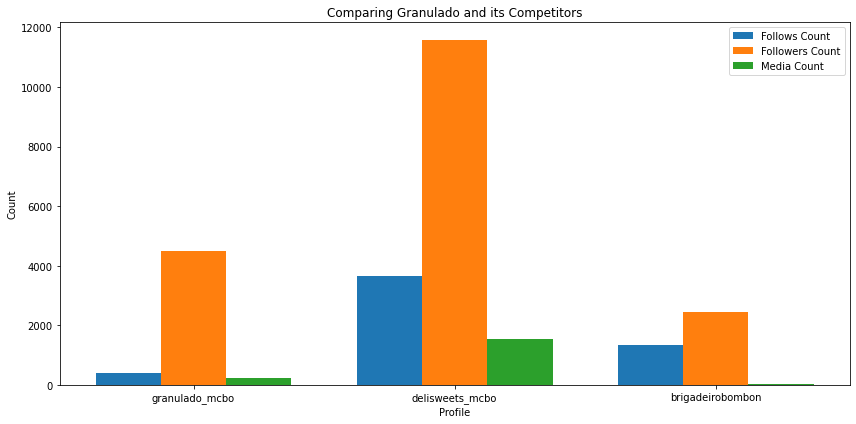

In [48]:
# Create an array of profile indices
indices = np.arange(len(profile_info))

# Set the width of each bar
bar_width = 0.25

plt.figure(figsize=(12, 6))

# Plot the first bar (follows_count)
plt.bar(indices, profile_info['follows_count'], bar_width, label='Follows Count')

# Plot the second bar (followers_count)
plt.bar(indices + bar_width, profile_info['followers_count'], bar_width, label='Followers Count')

# Plot the third bar (media_count)
plt.bar(indices + 2*bar_width, profile_info['media_count'], bar_width, label='Media Count')

# Set the x-axis labels to be the profile names
plt.xticks(indices + bar_width, profile_info['username'])

plt.xlabel('Profile')
plt.ylabel('Count')
plt.title('Comparing Granulado and its Competitors')
plt.legend()
plt.tight_layout()
plt.show()

### Total Engagement  Over Time

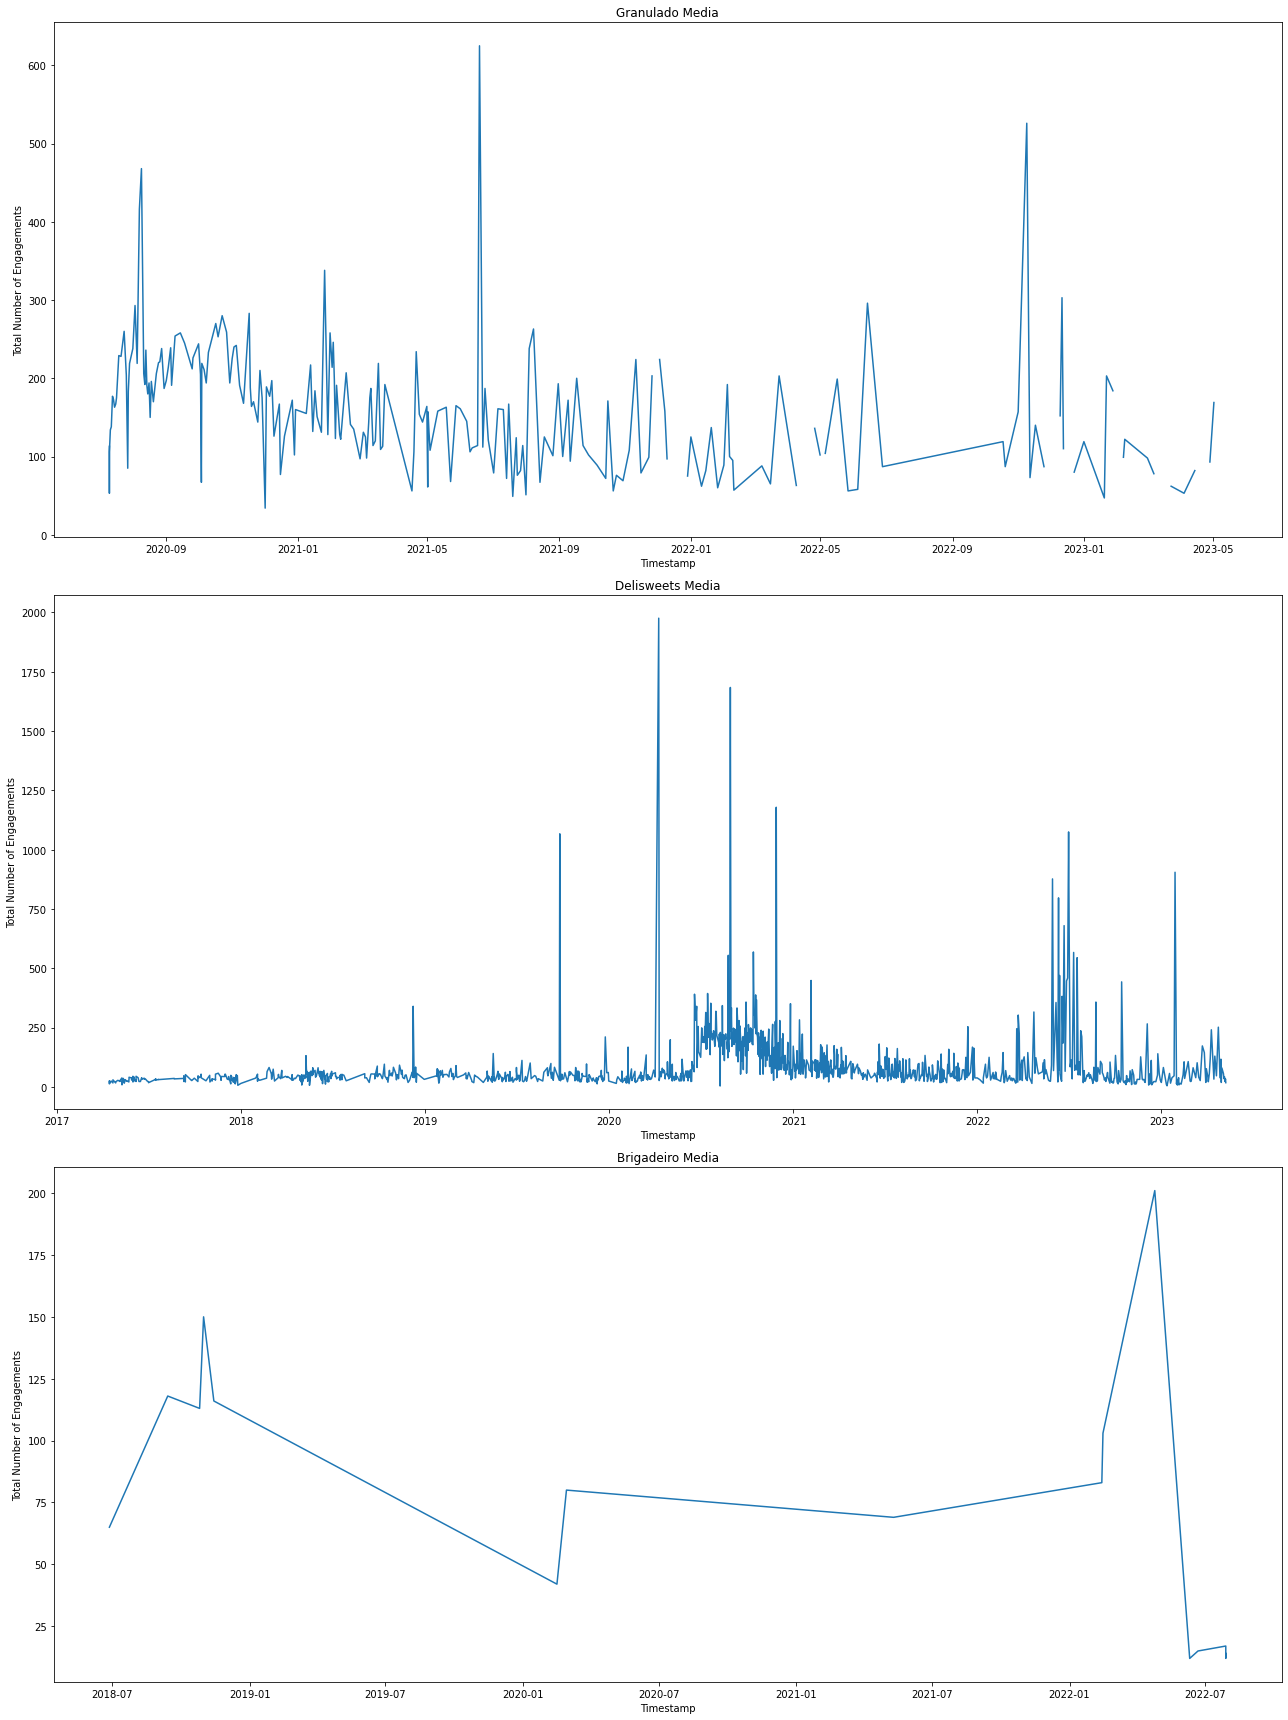

In [9]:
# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 24))

# Plot for granulado_media
axs[0].plot(granulado_media['timestamp'], granulado_media['Total Engagements'])
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Total Number of Engagements')
axs[0].set_title('Granulado Media')

# Plot for delisweets_media
axs[1].plot(delisweets_media['timestamp'], delisweets_media['Total Engagements'])
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Total Number of Engagements')
axs[1].set_title('Delisweets Media')

# Plot for brigadeiro_media
axs[2].plot(brigadeiro_media['timestamp'], brigadeiro_media['Total Engagements'])
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Total Number of Engagements')
axs[2].set_title('Brigadeiro Media')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Change in the total engagement over time

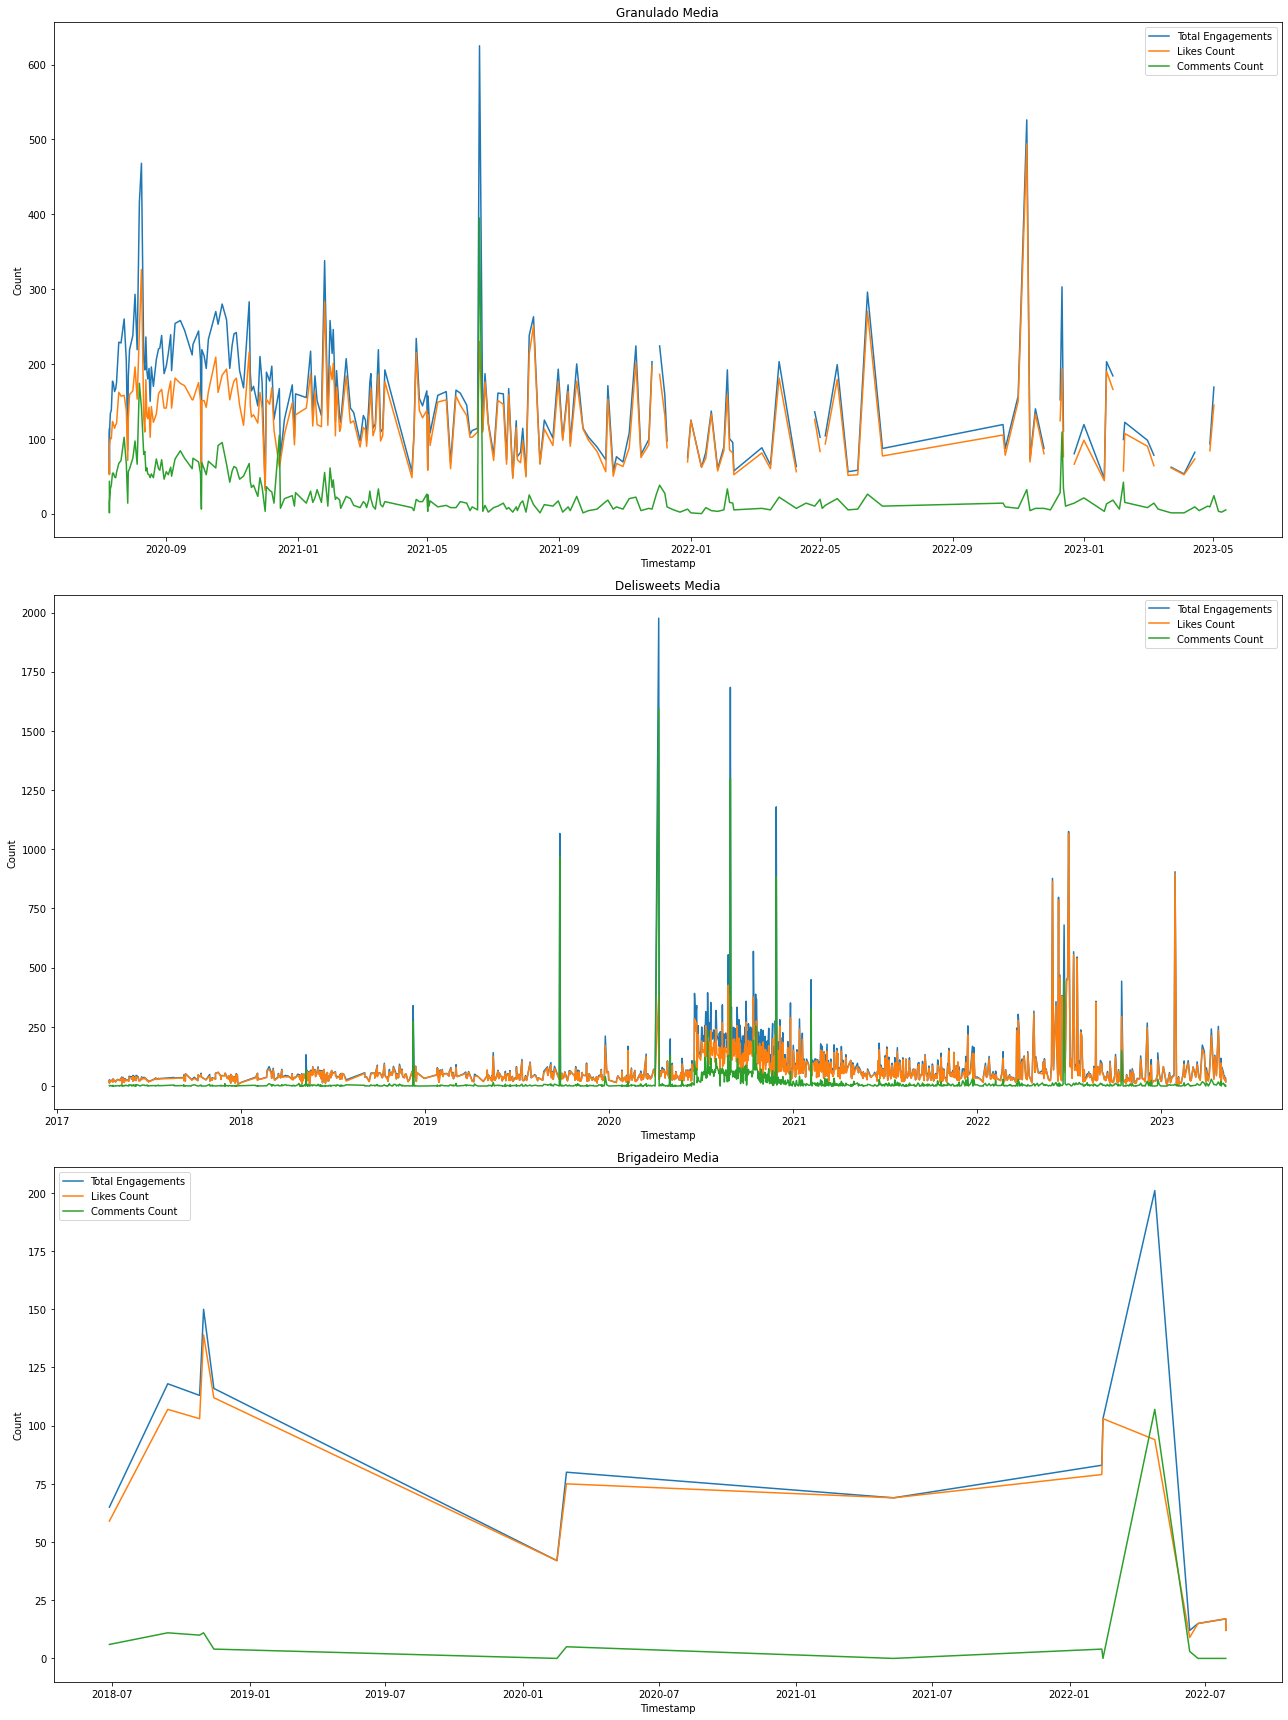

In [10]:
# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 24))

# Plot for granulado_media
axs[0].plot(granulado_media['timestamp'], granulado_media['Total Engagements'], label='Total Engagements')
axs[0].plot(granulado_media['timestamp'], granulado_media['like_count'], label='Likes Count')
axs[0].plot(granulado_media['timestamp'], granulado_media['comments_count'], label='Comments Count')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Count')
axs[0].set_title('Granulado Media')
axs[0].legend()

# Plot for delisweets_media
axs[1].plot(delisweets_media['timestamp'], delisweets_media['Total Engagements'], label='Total Engagements')
axs[1].plot(delisweets_media['timestamp'], delisweets_media['like_count'], label='Likes Count')
axs[1].plot(delisweets_media['timestamp'], delisweets_media['comments_count'], label='Comments Count')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Count')
axs[1].set_title('Delisweets Media')
axs[1].legend()

# Plot for brigadeiro_media
axs[2].plot(brigadeiro_media['timestamp'], brigadeiro_media['Total Engagements'], label='Total Engagements')
axs[2].plot(brigadeiro_media['timestamp'], brigadeiro_media['like_count'], label='Likes Count')
axs[2].plot(brigadeiro_media['timestamp'], brigadeiro_media['comments_count'], label='Comments Count')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Count')
axs[2].set_title('Brigadeiro Media')
axs[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Total Engagement per Hour

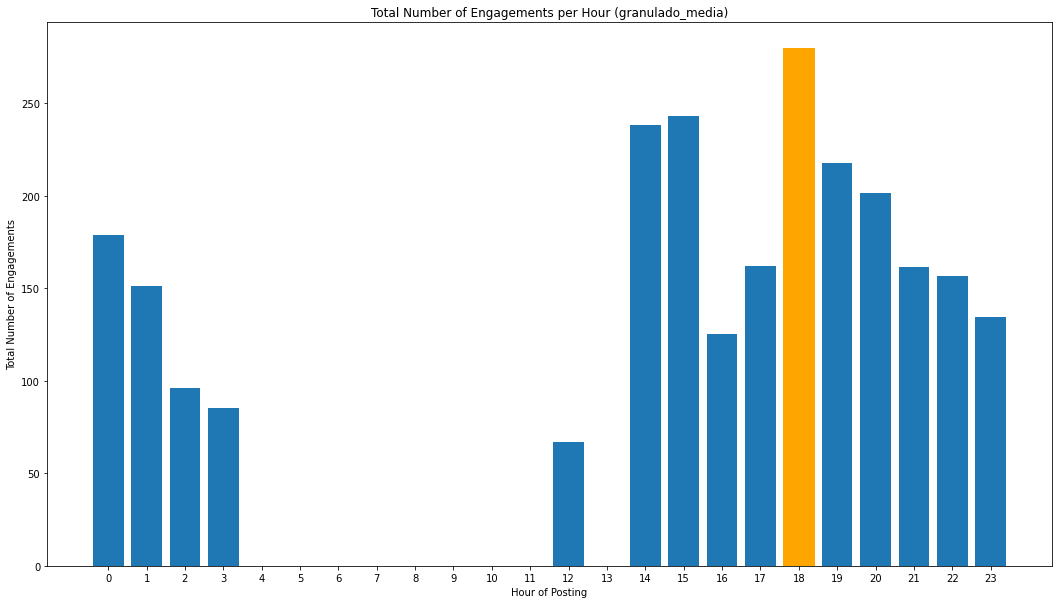

In [11]:
# Calculate the total engagements per hour
engagements_per_hour = granulado_media.groupby('Hour')['Total Engagements'].mean()

# Find the hour with the highest total engagements
max_engagements_hour = engagements_per_hour.idxmax()

# Plot a bar graph of the total engagements per hour
fig, ax = plt.subplots(figsize=(18, 10))
bars = ax.bar(engagements_per_hour.index, engagements_per_hour.values)

# Highlight the bar with the highest total engagements in grey
for i, bar in enumerate(bars):
    if engagements_per_hour.index[i] == max_engagements_hour:
        bar.set_color('orange')

ax.set_xlabel('Hour of Posting')
ax.set_ylabel('Total Number of Engagements')
ax.set_title('Total Number of Engagements per Hour (granulado_media)')
hour_ticks = np.arange(0, 24, 1)  # Hourly ticks from 0 to 23
ax.set_xticks(hour_ticks)
ax.set_xticklabels(hour_ticks)

# Display the plot
plt.show()

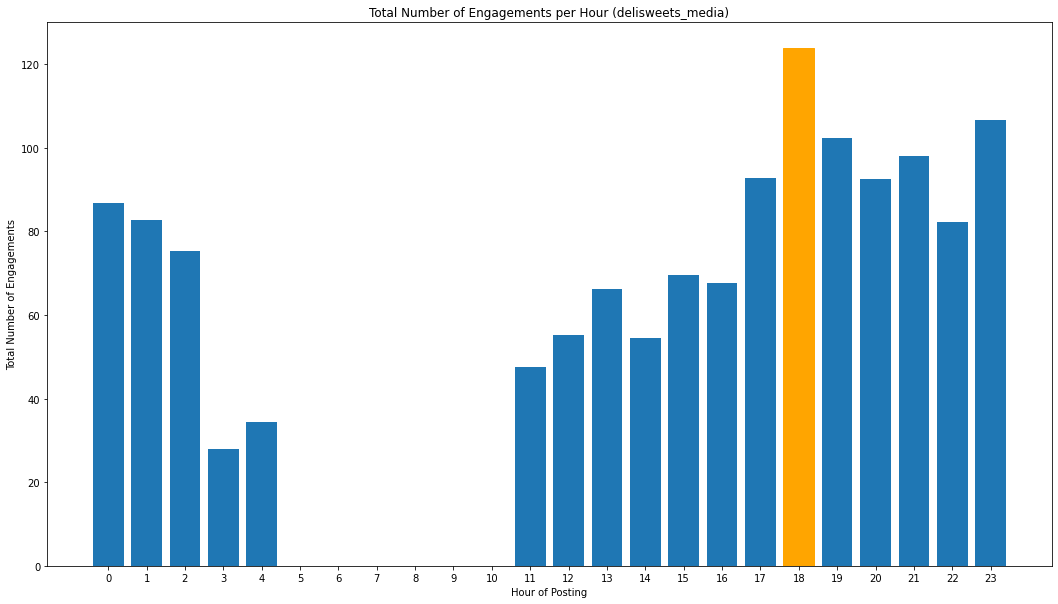

In [12]:
# Calculate the total engagements per hour
engagements_per_hour = delisweets_media.groupby('Hour')['Total Engagements'].mean()

# Find the hour with the highest total engagements
max_engagements_hour = engagements_per_hour.idxmax()

# Plot a bar graph of the total engagements per hour
fig, ax = plt.subplots(figsize=(18, 10))
bars = ax.bar(engagements_per_hour.index, engagements_per_hour.values)

# Highlight the bar with the highest total engagements in grey
for i, bar in enumerate(bars):
    if engagements_per_hour.index[i] == max_engagements_hour:
        bar.set_color('orange')

ax.set_xlabel('Hour of Posting')
ax.set_ylabel('Total Number of Engagements')
ax.set_title('Total Number of Engagements per Hour (delisweets_media)')
hour_ticks = np.arange(0, 24, 1)  # Hourly ticks from 0 to 23
ax.set_xticks(hour_ticks)
ax.set_xticklabels(hour_ticks)

# Display the plot
plt.show()

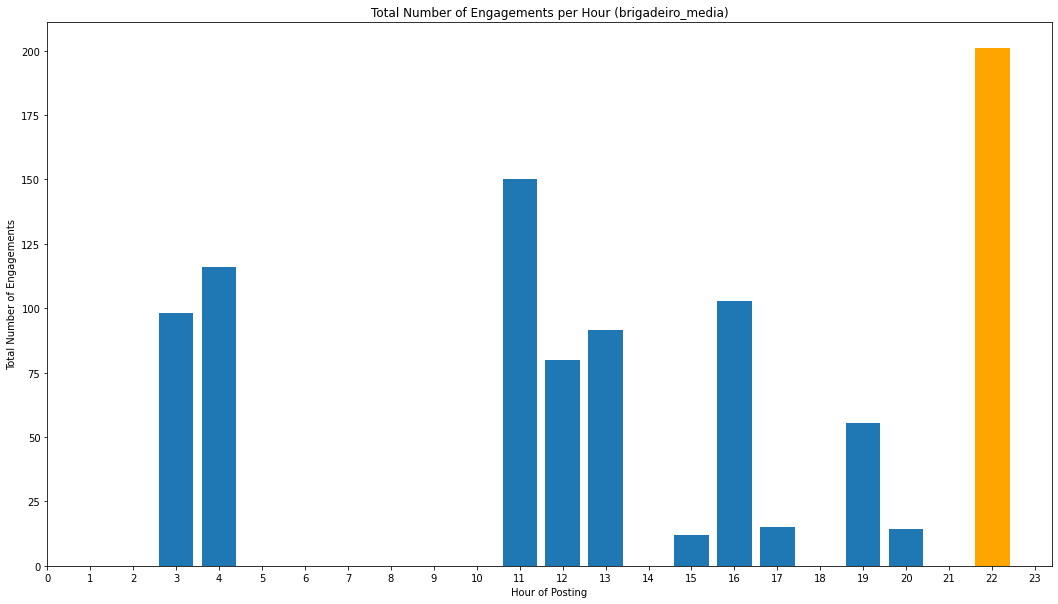

In [13]:
# Calculate the total engagements per hour
engagements_per_hour = brigadeiro_media.groupby('Hour')['Total Engagements'].mean()

# Find the hour with the highest total engagements
max_engagements_hour = engagements_per_hour.idxmax()

# Plot a bar graph of the total engagements per hour
fig, ax = plt.subplots(figsize=(18, 10))
bars = ax.bar(engagements_per_hour.index, engagements_per_hour.values)

# Highlight the bar with the highest total engagements in grey
for i, bar in enumerate(bars):
    if engagements_per_hour.index[i] == max_engagements_hour:
        bar.set_color('orange')

ax.set_xlabel('Hour of Posting')
ax.set_ylabel('Total Number of Engagements')
ax.set_title('Total Number of Engagements per Hour (brigadeiro_media)')
hour_ticks = np.arange(0, 24, 1)  # Hourly ticks from 0 to 23
ax.set_xticks(hour_ticks)
ax.set_xticklabels(hour_ticks)

# Display the plot
plt.show()

> On average, people engage the most at around 6:00 PM

## Total Engagements per Day of the Month

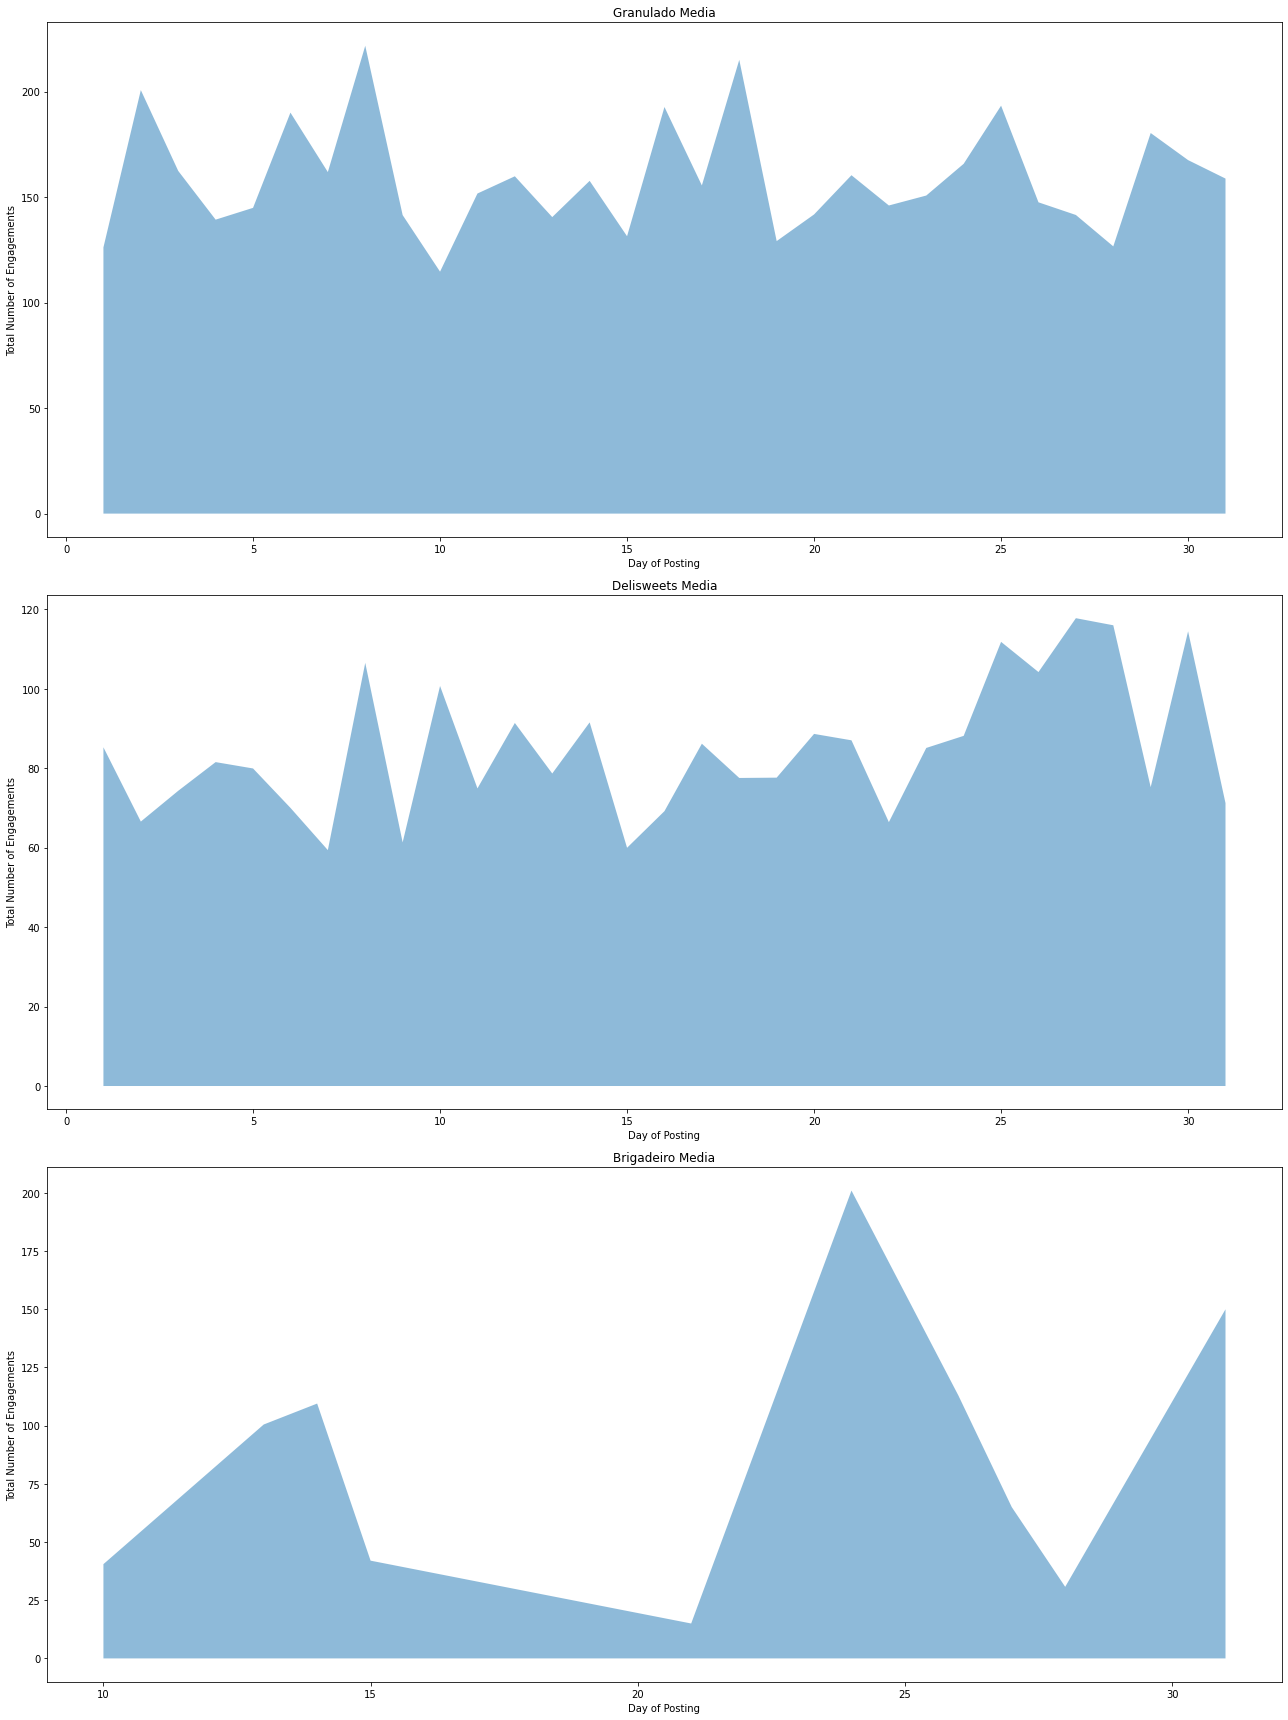

In [14]:
# Calculate the total engagements per day
engagements_per_day_granulado = granulado_media.groupby('Day of the Month')['Total Engagements'].mean()
engagements_per_day_delisweets = delisweets_media.groupby('Day of the Month')['Total Engagements'].mean()
engagements_per_day_brigadeiro = brigadeiro_media.groupby('Day of the Month')['Total Engagements'].mean()

# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 24))

# Plot for granulado_media
axs[0].fill_between(engagements_per_day_granulado.index, engagements_per_day_granulado.values, alpha=0.5)
axs[0].set_xlabel('Day of Posting')
axs[0].set_ylabel('Total Number of Engagements')
axs[0].set_title('Granulado Media')

# Plot for delisweets_media
axs[1].fill_between(engagements_per_day_delisweets.index, engagements_per_day_delisweets.values, alpha=0.5)
axs[1].set_xlabel('Day of Posting')
axs[1].set_ylabel('Total Number of Engagements')
axs[1].set_title('Delisweets Media')

# Plot for brigadeiro_media
axs[2].fill_between(engagements_per_day_brigadeiro.index, engagements_per_day_brigadeiro.values, alpha=0.5)
axs[2].set_xlabel('Day of Posting')
axs[2].set_ylabel('Total Number of Engagements')
axs[2].set_title('Brigadeiro Media')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Total Engagement per Day of the Week

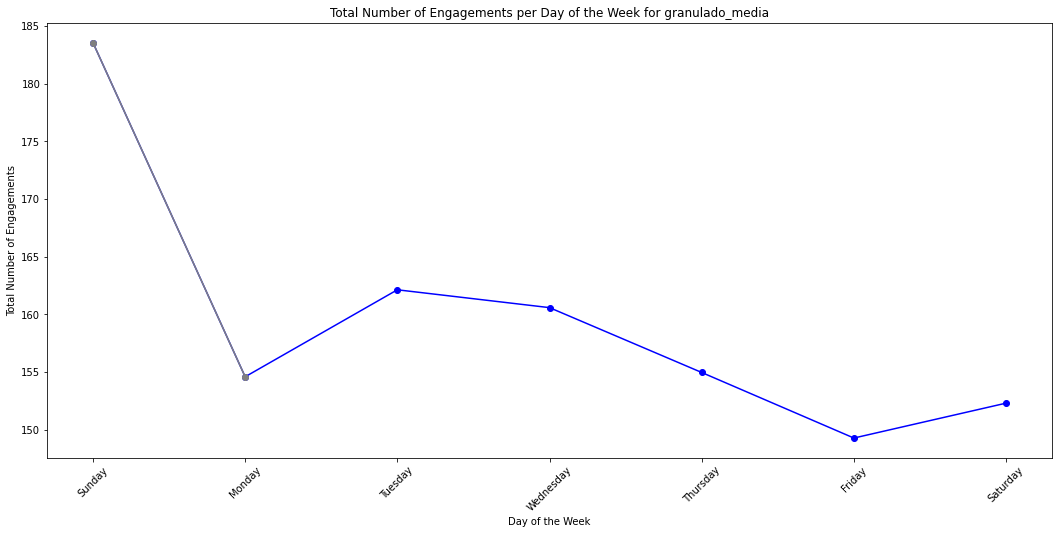

In [15]:
# Calculate the total engagements per day of the week
custom_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
engagements_per_day_of_week = granulado_media.groupby('Day of the Week')['Total Engagements'].mean().reindex(custom_order)

plt.figure(figsize=(18, 8))
plt.plot(engagements_per_day_of_week.index, engagements_per_day_of_week.values, marker='o', color='blue')
plt.plot(['Sunday', 'Monday'], [engagements_per_day_of_week['Sunday'], engagements_per_day_of_week['Monday']], marker='o', color='grey')
plt.xlabel('Day of the Week')
plt.ylabel('Total Number of Engagements')
plt.title('Total Number of Engagements per Day of the Week for granulado_media')
plt.xticks(rotation=45)
plt.show()

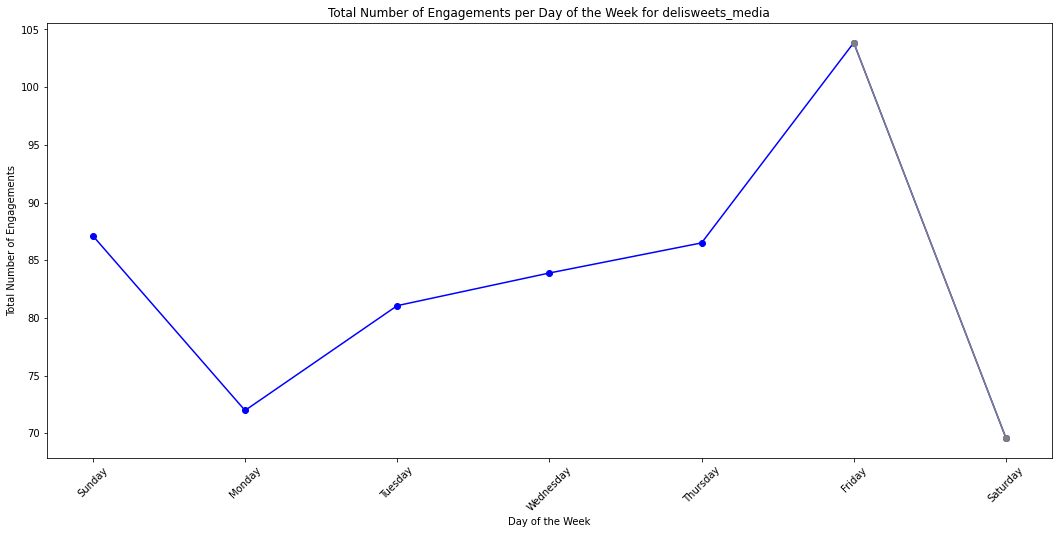

In [16]:
# Calculate the total engagements per day of the week
custom_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
engagements_per_day_of_week = delisweets_media.groupby('Day of the Week')['Total Engagements'].mean().reindex(custom_order)

plt.figure(figsize=(18, 8))
plt.plot(engagements_per_day_of_week.index, engagements_per_day_of_week.values, marker='o', color='blue')
plt.plot(['Friday', 'Saturday'], [engagements_per_day_of_week['Friday'], engagements_per_day_of_week['Saturday']], marker='o', color='grey')
plt.xlabel('Day of the Week')
plt.ylabel('Total Number of Engagements')
plt.title('Total Number of Engagements per Day of the Week for delisweets_media')
plt.xticks(rotation=45)
plt.show()

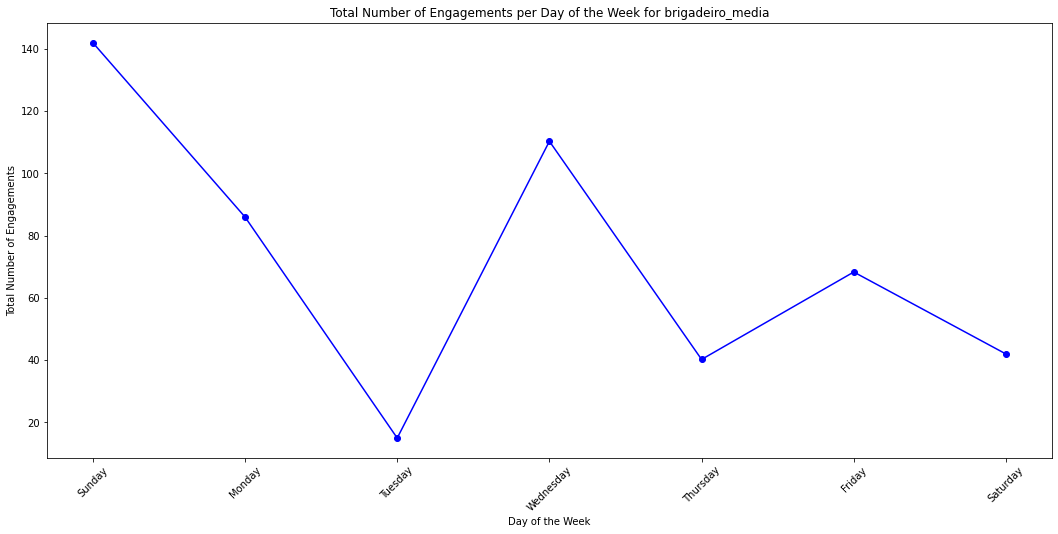

In [17]:
# Calculate the total engagements per day of the week
custom_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
engagements_per_day_of_week = brigadeiro_media.groupby('Day of the Week')['Total Engagements'].mean().reindex(custom_order)

plt.figure(figsize=(18, 8))
plt.plot(engagements_per_day_of_week.index, engagements_per_day_of_week.values, marker='o', color='blue')
plt.xlabel('Day of the Week')
plt.ylabel('Total Number of Engagements')
plt.title('Total Number of Engagements per Day of the Week for brigadeiro_media')
plt.xticks(rotation=45)
plt.show()

> On average, people engage most with Granulado on Sundays (maybe a weekend)

## Total Engagements per Month

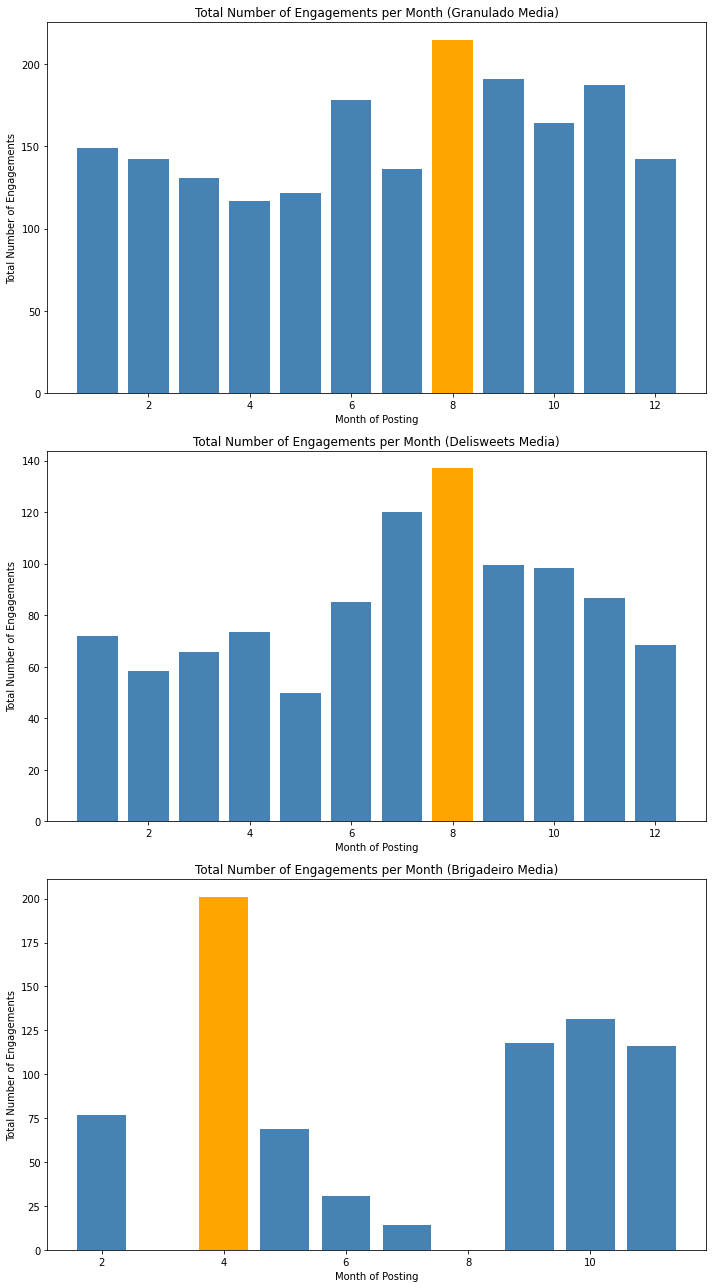

In [18]:
# Calculate the total engagements per month for each media
engagements_per_month_granulado = granulado_media.groupby('Month')['Total Engagements'].mean()
# Find the index of the highest bar
highest_bar_index = engagements_per_month_granulado.idxmax()
# Set the color for each bar, highlighting the highest bar with a different color
colors_granulado = ['steelblue' if i != highest_bar_index else 'orange' for i in engagements_per_month_granulado.index]

engagements_per_month_delisweets = delisweets_media.groupby('Month')['Total Engagements'].mean()
# Find the index of the highest bar
highest_bar_index = engagements_per_month_delisweets.idxmax()
# Set the color for each bar, highlighting the highest bar with a different color
colors_delisweets = ['steelblue' if i != highest_bar_index else 'orange' for i in engagements_per_month_delisweets.index]

engagements_per_month_brigadeiro = brigadeiro_media.groupby('Month')['Total Engagements'].mean()
# Find the index of the highest bar
highest_bar_index = engagements_per_month_brigadeiro.idxmax()
# Set the color for each bar, highlighting the highest bar with a different color
colors_brigadeiro = ['steelblue' if i != highest_bar_index else 'orange' for i in engagements_per_month_brigadeiro.index]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Scatter plot for granulado_media
axs[0].bar(engagements_per_month_granulado.index, engagements_per_month_granulado.values, color = colors_granulado)
axs[0].set_xlabel('Month of Posting')
axs[0].set_ylabel('Total Number of Engagements')
axs[0].set_title('Total Number of Engagements per Month (Granulado Media)')

# Scatter plot for delisweets_media
axs[1].bar(engagements_per_month_delisweets.index, engagements_per_month_delisweets.values, color = colors_delisweets)
axs[1].set_xlabel('Month of Posting')
axs[1].set_ylabel('Total Number of Engagements')
axs[1].set_title('Total Number of Engagements per Month (Delisweets Media)')

# Scatter plot for brigadeiro_media
axs[2].bar(engagements_per_month_brigadeiro.index, engagements_per_month_brigadeiro.values, color = colors_brigadeiro)
axs[2].set_xlabel('Month of Posting')
axs[2].set_ylabel('Total Number of Engagements')
axs[2].set_title('Total Number of Engagements per Month (Brigadeiro Media)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

> On average, users engage the most on August (summer vacation)

## Total Engagements per Season

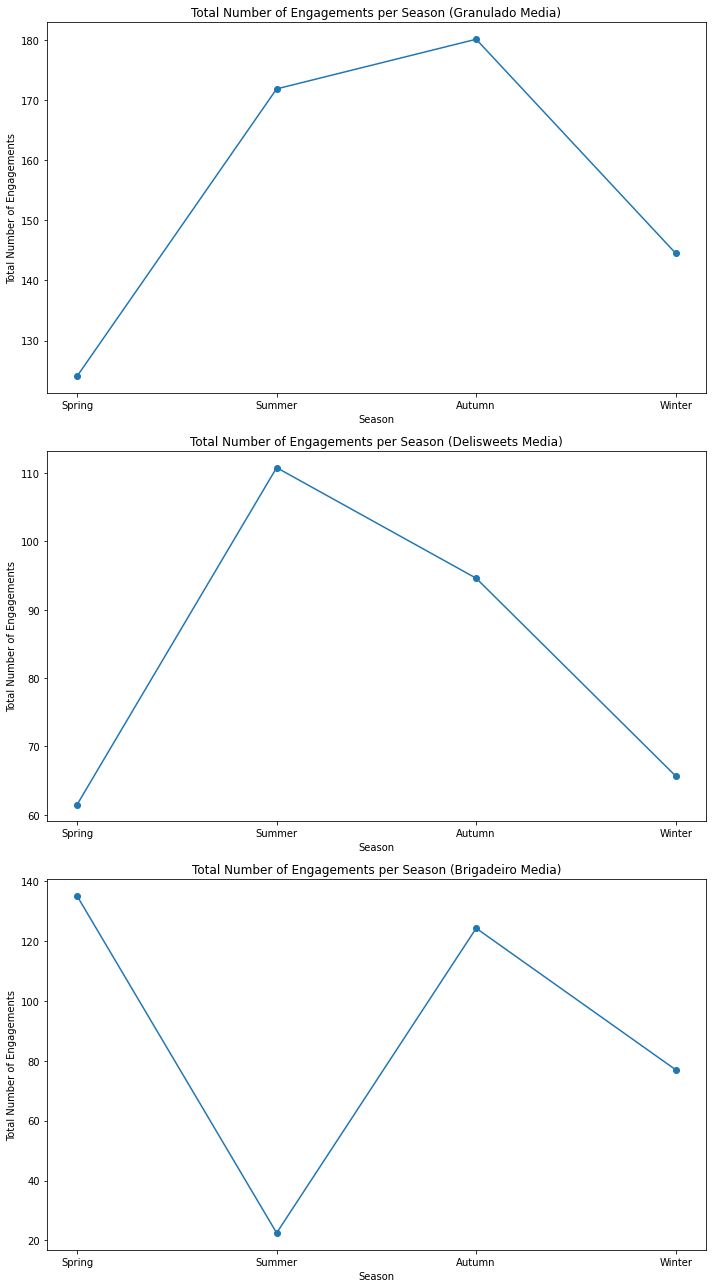

In [19]:
# Calculate the total engagements per season
custom_order = ['Spring', 'Summer', 'Autumn', 'Winter']
# Calculate the total engagements per season for each media
engagements_per_season_granulado = granulado_media.groupby('Season')['Total Engagements'].mean().reindex(custom_order)
engagements_per_season_delisweets = delisweets_media.groupby('Season')['Total Engagements'].mean().reindex(custom_order)
engagements_per_season_brigadeiro = brigadeiro_media.groupby('Season')['Total Engagements'].mean().reindex(custom_order)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot for granulado_media
axs[0].plot(engagements_per_season_granulado.index, engagements_per_season_granulado.values, marker='o')
axs[0].set_xlabel('Season')
axs[0].set_ylabel('Total Number of Engagements')
axs[0].set_title('Total Number of Engagements per Season (Granulado Media)')

# Plot for delisweets_media
axs[1].plot(engagements_per_season_delisweets.index, engagements_per_season_delisweets.values, marker='o')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Total Number of Engagements')
axs[1].set_title('Total Number of Engagements per Season (Delisweets Media)')

# Plot for brigadeiro_media
axs[2].plot(engagements_per_season_brigadeiro.index, engagements_per_season_brigadeiro.values, marker='o')
axs[2].set_xlabel('Season')
axs[2].set_ylabel('Total Number of Engagements')
axs[2].set_title('Total Number of Engagements per Season (Brigadeiro Media)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Total Engagements per Part of the Day

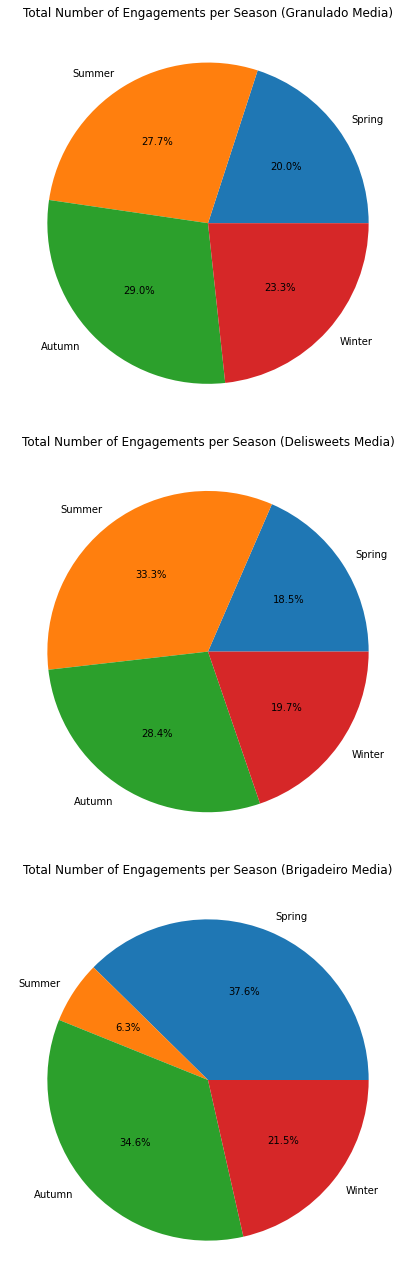

In [20]:
# Calculate the total engagements per season for each media
engagements_per_season_granulado = granulado_media.groupby('Season')['Total Engagements'].mean().reindex(custom_order)
engagements_per_season_delisweets = delisweets_media.groupby('Season')['Total Engagements'].mean().reindex(custom_order)
engagements_per_season_brigadeiro = brigadeiro_media.groupby('Season')['Total Engagements'].mean().reindex(custom_order)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot for granulado_media
axs[0].pie(engagements_per_season_granulado.values, labels=engagements_per_season_granulado.index, autopct='%1.1f%%')
axs[0].set_title('Total Number of Engagements per Season (Granulado Media)')

# Plot for delisweets_media
axs[1].pie(engagements_per_season_delisweets.values, labels=engagements_per_season_delisweets.index, autopct='%1.1f%%')
axs[1].set_title('Total Number of Engagements per Season (Delisweets Media)')

# Plot for brigadeiro_media
axs[2].pie(engagements_per_season_brigadeiro.values, labels=engagements_per_season_brigadeiro.index, autopct='%1.1f%%')
axs[2].set_title('Total Number of Engagements per Season (Brigadeiro Media)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Total Engagements per Part of the Day

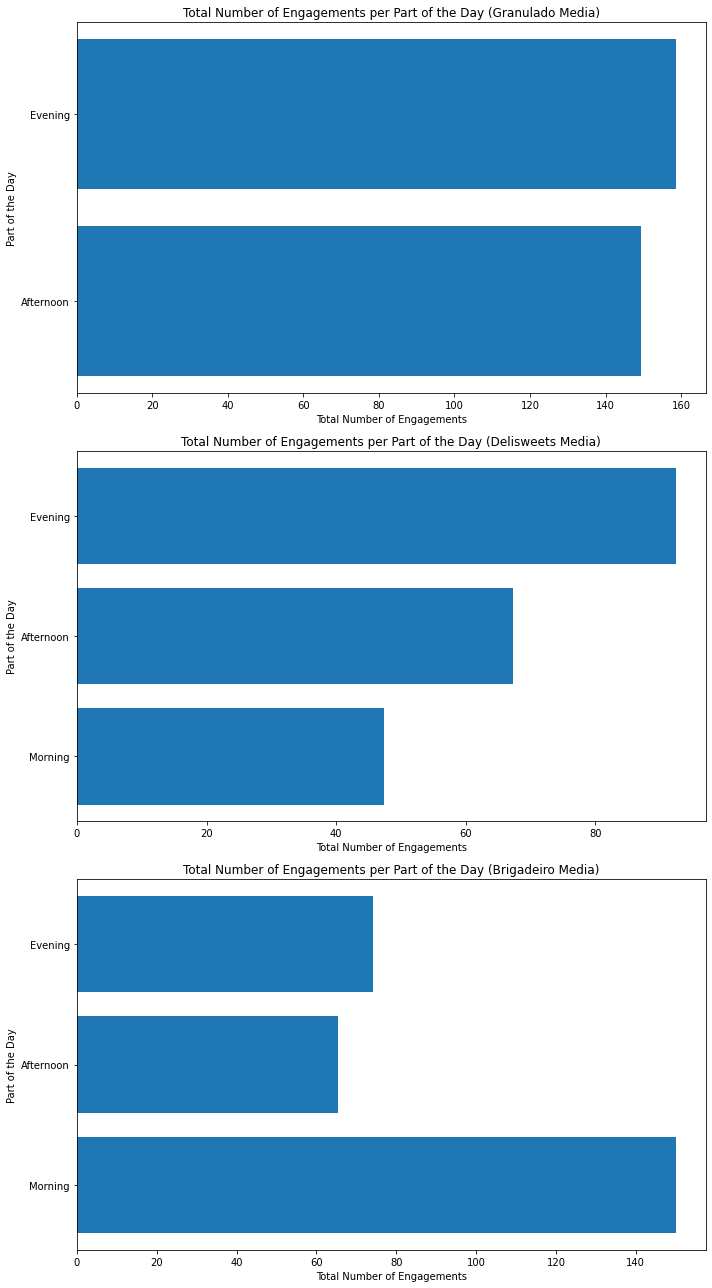

In [21]:
# Calculate the total engagements per part of the day
custom_order = ['Morning', 'Afternoon', 'Evening']
# Calculate the total engagements per part of the day for each media
engagements_per_part_of_day_granulado = granulado_media.groupby('Part of the Day')['Total Engagements'].mean().reindex(custom_order)
engagements_per_part_of_day_delisweets = delisweets_media.groupby('Part of the Day')['Total Engagements'].mean().reindex(custom_order)
engagements_per_part_of_day_brigadeiro = brigadeiro_media.groupby('Part of the Day')['Total Engagements'].mean().reindex(custom_order)


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot for granulado_media
axs[0].bar(engagements_per_part_of_day_granulado.index, engagements_per_part_of_day_granulado.values)
axs[0].set_xlabel('Total Number of Engagements')
axs[0].set_ylabel('Part of the Day')
axs[0].set_title('Total Number of Engagements per Part of the Day (Granulado Media)')

# Plot for delisweets_media
axs[1].bar(engagements_per_part_of_day_delisweets.index, engagements_per_part_of_day_delisweets.values)
axs[1].set_xlabel('Total Number of Engagements')
axs[1].set_ylabel('Part of the Day')
axs[1].set_title('Total Number of Engagements per Part of the Day (Delisweets Media)')

# Plot for brigadeiro_media
axs[2].bar(engagements_per_part_of_day_brigadeiro.index, engagements_per_part_of_day_brigadeiro.values)
axs[2].set_xlabel('Total Number of Engagements')
axs[2].set_ylabel('Part of the Day')
axs[2].set_title('Total Number of Engagements per Part of the Day (Brigadeiro Media)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Total Engagements per Post Type

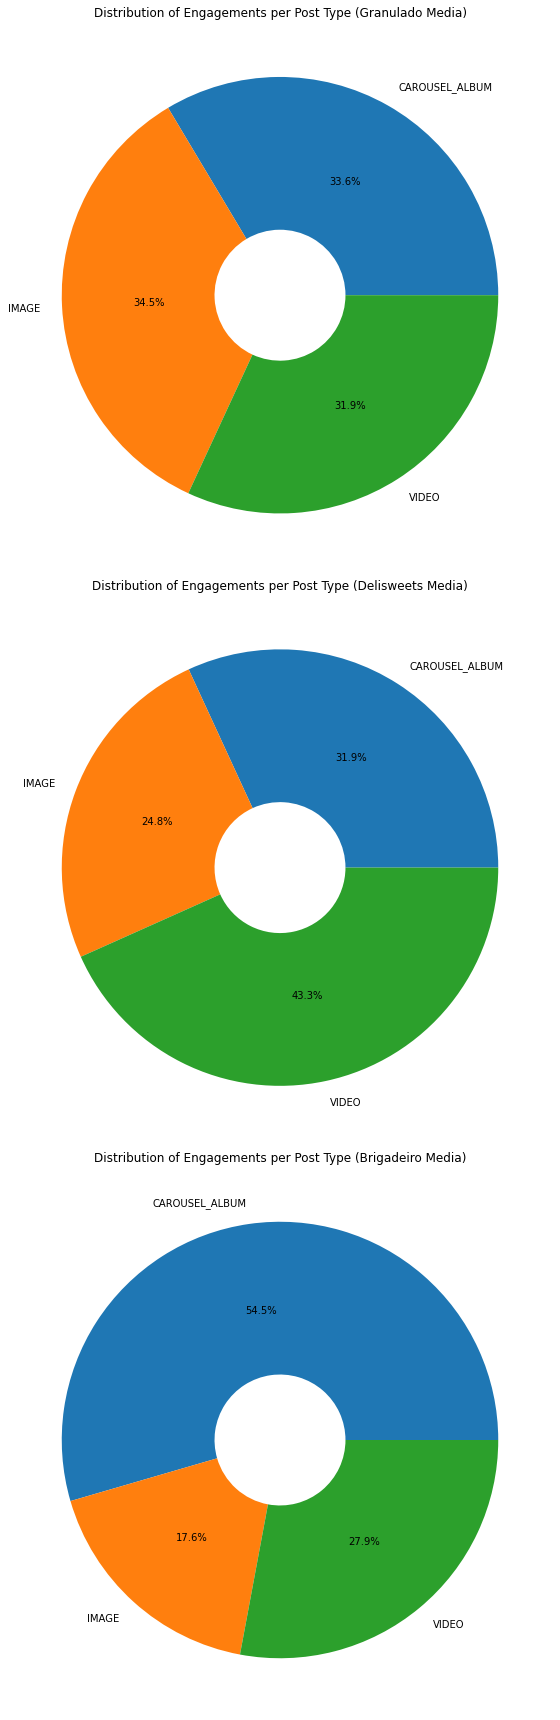

In [22]:
# Calculate the total engagements per media type for each media
engagements_per_media_type_granulado = granulado_media.groupby('media_type')['Total Engagements'].mean()
engagements_per_media_type_delisweets = delisweets_media.groupby('media_type')['Total Engagements'].mean()
engagements_per_media_type_brigadeiro = brigadeiro_media.groupby('media_type')['Total Engagements'].mean()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 24))

# Plot for granulado_media
axs[0].pie(engagements_per_media_type_granulado.values, labels=engagements_per_media_type_granulado.index, autopct='%1.1f%%', wedgeprops=dict(width=0.7))
axs[0].set_title('Distribution of Engagements per Post Type (Granulado Media)')

# Plot for delisweets_media
axs[1].pie(engagements_per_media_type_delisweets.values, labels=engagements_per_media_type_delisweets.index, autopct='%1.1f%%', wedgeprops=dict(width=0.7))
axs[1].set_title('Distribution of Engagements per Post Type (Delisweets Media)')

# Plot for brigadeiro_media
axs[2].pie(engagements_per_media_type_brigadeiro.values, labels=engagements_per_media_type_brigadeiro.index, autopct='%1.1f%%', wedgeprops=dict(width=0.7))
axs[2].set_title('Distribution of Engagements per Post Type (Brigadeiro Media)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Total Engagements Per Post Product Type

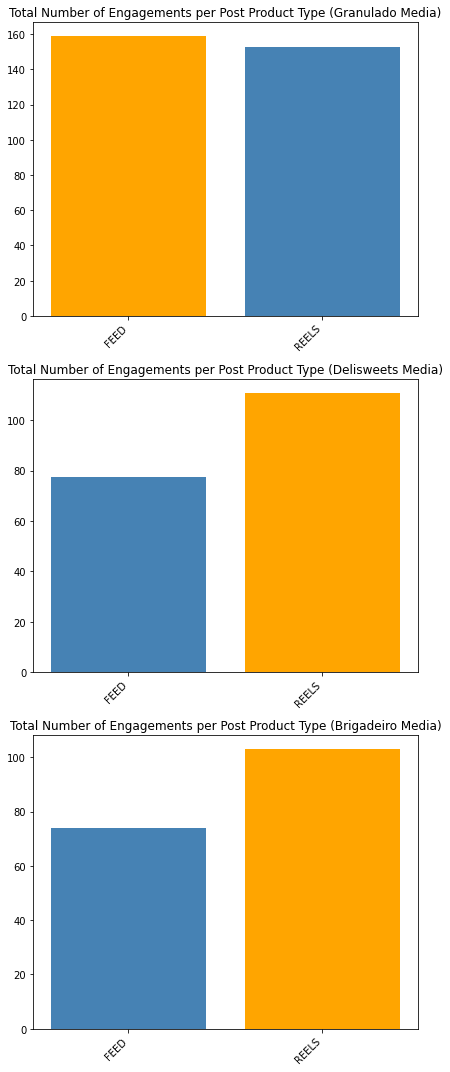

In [28]:
# Calculate the total engagements per post product type for each media
engagements_per_media_product_type_granulado = granulado_media.groupby('media_product_type')['Total Engagements'].mean()
engagements_per_media_product_type_delisweets = delisweets_media.groupby('media_product_type')['Total Engagements'].mean()
engagements_per_media_product_type_brigadeiro = brigadeiro_media.groupby('media_product_type')['Total Engagements'].mean()

# Find the index of the highest bar
highest_bar_index = engagements_per_media_product_type_granulado.idxmax()
# Set the color for each bar, highlighting the highest bar with a different color
colors1 = ['steelblue' if i != highest_bar_index else 'orange' for i in engagements_per_media_product_type_granulado.index]

# Find the index of the highest bar
highest_bar_index = engagements_per_media_product_type_delisweets.idxmax()
# Set the color for each bar, highlighting the highest bar with a different color
colors2 = ['steelblue' if i != highest_bar_index else 'orange' for i in engagements_per_media_product_type_delisweets.index]

# Find the index of the highest bar
highest_bar_index = engagements_per_media_product_type_brigadeiro.idxmax()
# Set the color for each bar, highlighting the highest bar with a different color
colors3= ['steelblue' if i != highest_bar_index else 'orange' for i in engagements_per_media_product_type_brigadeiro.index]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 15))

# Plot for granulado_media
axs[0].bar(engagements_per_media_product_type_granulado.index, engagements_per_media_product_type_granulado.values, color = colors1)
axs[0].set_title('Total Number of Engagements per Post Product Type (Granulado Media)')

# Plot for delisweets_media
axs[1].bar(engagements_per_media_product_type_delisweets.index, engagements_per_media_product_type_delisweets.values, color = colors2)
axs[1].set_title('Total Number of Engagements per Post Product Type (Delisweets Media)')

# Plot for brigadeiro_media
axs[2].bar(engagements_per_media_product_type_brigadeiro.index, engagements_per_media_product_type_brigadeiro.values, color = colors2)
axs[2].set_title('Total Number of Engagements per Post Product Type (Brigadeiro Media)')

# Customize aesthetics and layout
bar_width = 0.6
x = np.arange(len(engagements_per_media_product_type_granulado))
for ax in axs:
    ax.set_xticks(x)
    ax.set_xticklabels(engagements_per_media_product_type_granulado.index, rotation=45, ha='right')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Comments Sentiment Analysis

In [24]:
granulado_media[['Total Engagements', 'comments']]

,Total Engagements,comments
0,27.0,"[{'likes': 0, 'text': 'Perfecto 👌🏻😍', 'timesta..."
1,NaN,"[{'likes': 0, 'text': '😍😍😍', 'timestamp': '202..."
2,NaN,"[{'likes': 0, 'text': '😍😍😍', 'timestamp': '202..."
3,169.0,"[{'likes': 0, 'text': '❤️❤️❤️❤️', 'timestamp':..."
4,93.0,"[{'likes': 0, 'text': '👏❤️', 'timestamp': '202..."
...,...,...
231,61.0,"[{'likes': 0, 'text': 'Lo q mas amoo🔥🔥🔥🔥🔥', 't..."
232,53.0,"[{'likes': 1, 'text': 'Amoooo ese brigadero!!'..."
233,55.0,"[{'likes': 0, 'text': '😍😍', 'timestamp': '2020..."
234,60.0,"[{'likes': 1, 'text': 'Me puedo comer 10 senta..."


In [25]:
comment_texts = []
engagements = []
for index, row in granulado_media.iterrows():
    total_engagements = row['Total Engagements']
    comments = row['comments']
    for comment in comments:
        comment_text = comment['text']
        comment_texts.append(comment_text)
        engagements.append(total_engagements)

# Create a new DataFrame with the extracted data
comments_data = pd.DataFrame({'Comment': comment_texts, 'Total Engagements': engagements})

In [26]:
comments_data

,Comment,Total Engagements
0,Perfecto 👌🏻😍,27.0
1,Wowww🔥❤️,27.0
2,🤤🤤🤤🤤😍,27.0
3,😍😍😍,27.0
4,🔥❤️,27.0
...,...,...
1328,👏👏👌😍,113.0
1329,Exitossss,113.0
1330,👏👏👏👏muchos éxitos,113.0
1331,Muchos éxitos en este emprendimiento hbbti 👏😘😍,113.0


In [27]:
# Save the DataFrame to a CSV file
comments_data.to_csv('insights_data/comments_data.csv', index=False)

In [28]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Create empty lists to store positive and negative scores
positive_scores = []
negative_scores = []

# Loop through each comment in the DataFrame
for comment_text in comments_data['Comment']:
    # Use VADER to get the positive and negative scores
    sentiment_scores = sia.polarity_scores(comment_text)
    positive_score = sentiment_scores['pos']
    negative_score = sentiment_scores['neg']
    
    # Add the scores to the lists
    positive_scores.append(positive_score)
    negative_scores.append(negative_score)

# Create a new DataFrame to store the sentiment analysis results
sentiment_analysis = pd.DataFrame({
    'Comment': comments_data['Comment'],
    'Total Engagements': comments_data['Total Engagements'],
    'Positive Score': positive_scores,
    'Negative Score': negative_scores,
})

# Calculate the overall sentiment score
sentiment_analysis['Sentiment Score'] = sentiment_analysis['Positive Score'] - sentiment_analysis['Negative Score']

# Sort the DataFrame by sentiment score
sentiment_analysis_sorted = sentiment_analysis.sort_values('Sentiment Score', ascending=False)

# Print the sentiment analysis results
print(sentiment_analysis_sorted)

                                        Comment  Total Engagements  \
67                                          Wow              119.0   
433                             Wow!! Amazing 😍              106.0   
385                                 Perfectas 😍              167.0   
381                                    I want 😢              124.0   
379                                       Yummy              124.0   
...                                         ...                ...   
783                    Yo quiero agendar la mia              170.0   
1232                      Si , no lo he probado              229.0   
1222  Extremo quedaría como dos días sin dormir              260.0   
1087     De todooos! No discrimino chocolate! 🤤              196.0   
371                  Eso no provoca comerselo😍😍               82.0   

      Positive Score  Negative Score  Sentiment Score  
67               1.0           0.000            1.000  
433              1.0           0.000           

In [29]:
sentiment_analysis_sorted.to_csv('insights_data/sentiment_analysis_sorted.csv', index=False)

In [30]:
# Calculate the correlation between positivity and engagement
correlation_pos = sentiment_analysis_sorted['Positive Score'].corr(sentiment_analysis_sorted['Total Engagements'])

# Calculate the correlation between negativity and engagement
correlation_neg = sentiment_analysis_sorted['Negative Score'].corr(sentiment_analysis_sorted['Total Engagements'])

print(f"Correlation between positivity and engagement: {correlation_pos:.2f}")
print(f"Correlation between negativity and engagement: {correlation_neg:.2f}")

Correlation between positivity and engagement: -0.04
Correlation between negativity and engagement: 0.03


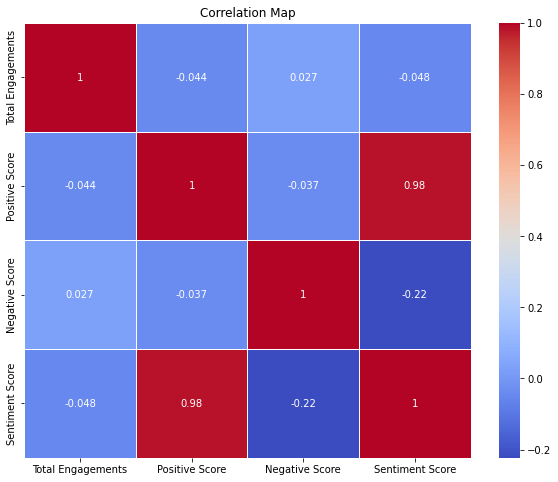

In [31]:
# Compute the correlation matrix
correlation_matrix = sentiment_analysis_sorted.corr()

# Create a correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
ax.set_title('Correlation Map')

# Display the plot
plt.show()

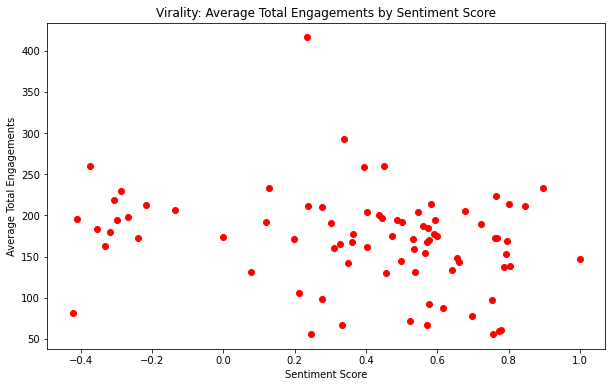

In [32]:
# Calculate the average total engagements for each sentiment score
avg_engagements_by_sentiment = sentiment_analysis_sorted.groupby('Sentiment Score')['Total Engagements'].mean()

# Create a scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(avg_engagements_by_sentiment.index, avg_engagements_by_sentiment.values, color='red')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Average Total Engagements')
ax.set_title('Virality: Average Total Engagements by Sentiment Score')

# Display the plot
plt.show()

# Hashtag Analysis

In [30]:
granulado_hashtags = granulado_media[['Hashtags', 'Total Engagements']]

In [31]:
granulado_hashtags = granulado_hashtags.dropna()
granulado_hashtags['Hashtag Present'] = granulado_hashtags['Hashtags'].apply(lambda x: 1 if len(x) > 0 else 0)

## Total Engagements by Hashtag Presence

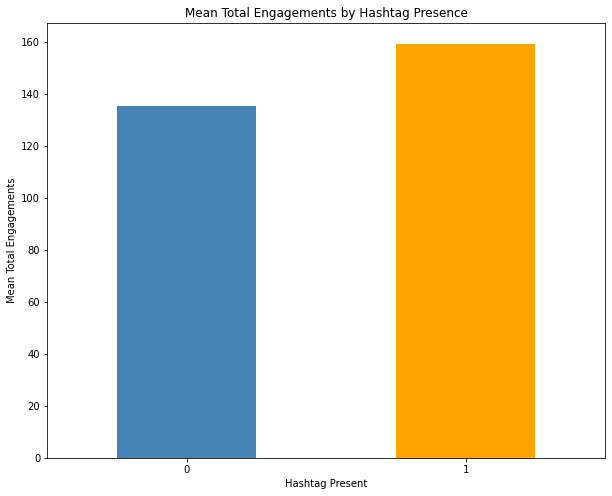

In [32]:
mean_engagement = granulado_hashtags.groupby('Hashtag Present')['Total Engagements'].mean()
# Find the index of the highest bar
highest_bar_index = mean_engagement.idxmax()
# Set the color for each bar, highlighting the highest bar with a different color
colors = ['steelblue' if i != highest_bar_index else 'orange' for i in mean_engagement.index]


plt.figure(figsize=(10, 8))
mean_engagement.plot(kind='bar', color = colors)
plt.xlabel('Hashtag Present')
plt.ylabel('Mean Total Engagements')
plt.title('Mean Total Engagements by Hashtag Presence')
plt.xticks(rotation=0)
plt.show()

> Posts with hashtags have higher total engagement than those without

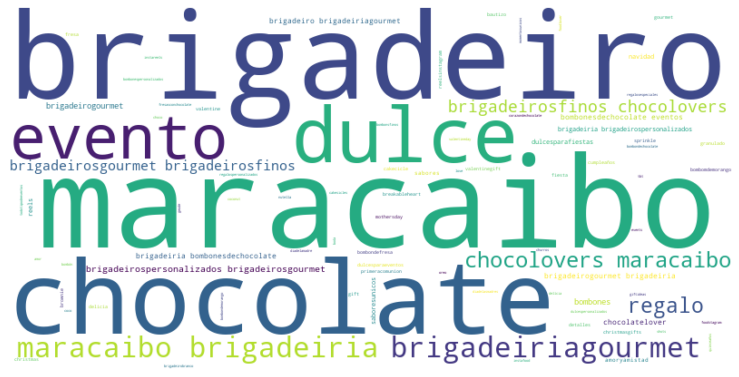

In [33]:
# Concatenate all hashtags into a single string
all_hashtags = ' '.join(granulado_hashtags['Hashtags'].sum())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_hashtags)

# Display the word cloud
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Finding the most effective hashtag

In [34]:
# Remove rows with empty brackets
granulado_with_hashtags = granulado_hashtags[granulado_hashtags['Hashtags'].apply(lambda x: len(x) > 0)]

In [35]:
# Ignore all warnings
warnings.filterwarnings('ignore')

# Extract all unique hashtags from the 'Hashtags' column
hashtags = set(tag for tags in granulado_with_hashtags['Hashtags'] for tag in tags)

# Create new binary variables for each hashtag:
for hashtag in hashtags:
    granulado_with_hashtags[hashtag] = granulado_with_hashtags['Hashtags'].apply(lambda x: int(hashtag in x))
    

# Drop the original 'Hashtags' column
granulado_with_hashtags = granulado_with_hashtags.drop('Hashtags', axis=1)

In [36]:
granulado_with_hashtags

,Total Engagements,Hashtag Present,valentinegift,evento,diadelamadre,inspiracion,yummyfood,bombomdemorango,bombomdeoreo,morango,...,doisamores,valentinegiftbox,valentineday,diadelpadre,felicesfiestas,beigadeiria,brigadeirocommorango,foodporn,cucharasdechocolate,felizlunes
0,27.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,169.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,93.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,82.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,53.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,163.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
226,173.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
227,177.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
228,138.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Sum the frequency of each hashtag across all rows
hashtags_freq = granulado_with_hashtags.iloc[:, 2:].sum().sort_values(ascending=False)

# Select the top 10 most used hashtags
top_10_hashtags = hashtags_freq.head(10).index.tolist()

# Filter the DataFrame to keep only the rows that contain at least one of the top 10 hashtags
granulado_with_top10_hashtags = granulado_with_hashtags.loc[:, ['Total Engagements'] + top_10_hashtags]
granulado_with_top10_hashtags = granulado_with_top10_hashtags[granulado_with_top10_hashtags[top_10_hashtags].any(axis=1)]

In [45]:
top_10_hashtags

['maracaibo',
 'brigadeiria',
 'brigadeiro',
 'chocolovers',
 'eventos',
 'brigadeiriagourmet',
 'brigadeirosgourmet',
 'chocolate',
 'brigadeirogourmet',
 'dulces']

In [38]:
granulado_with_top10_hashtags

,Total Engagements,maracaibo,brigadeiria,brigadeiro,chocolovers,eventos,brigadeiriagourmet,brigadeirosgourmet,chocolate,brigadeirogourmet,dulces
4,93.0,1,0,0,0,1,0,0,0,1,1
7,82.0,1,0,0,0,1,0,0,0,0,1
8,53.0,0,0,1,0,1,1,0,0,0,1
9,62.0,1,0,0,1,1,1,0,1,0,1
11,78.0,1,0,0,0,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
225,163.0,1,1,0,1,0,0,1,0,0,0
226,173.0,1,1,0,1,0,0,1,0,0,0
227,177.0,1,1,0,1,0,0,1,0,0,0
228,138.0,1,0,0,1,0,1,0,0,0,0


In [39]:
# grouping captions based on hashtag
df_hashtags = pd.DataFrame()

# Iterate over the columns (hashtags)
for column in granulado_with_top10_hashtags.columns:
    if column != 'Total Engagements':  # Exclude the 'total_engagement' column itself
        # Filter the DataFrame for each hashtag
        hashtag_df = granulado_with_top10_hashtags[granulado_with_top10_hashtags[column] == 1]
        
        # Calculate the average total engagement for the hashtag
        average_engagement = hashtag_df['Total Engagements'].mean()
        
        # Append the hashtag and its average total engagement to the new DataFrame
        df_hashtags = df_hashtags.append({'hashtag': column, 'average_engagement': average_engagement}, ignore_index=True)

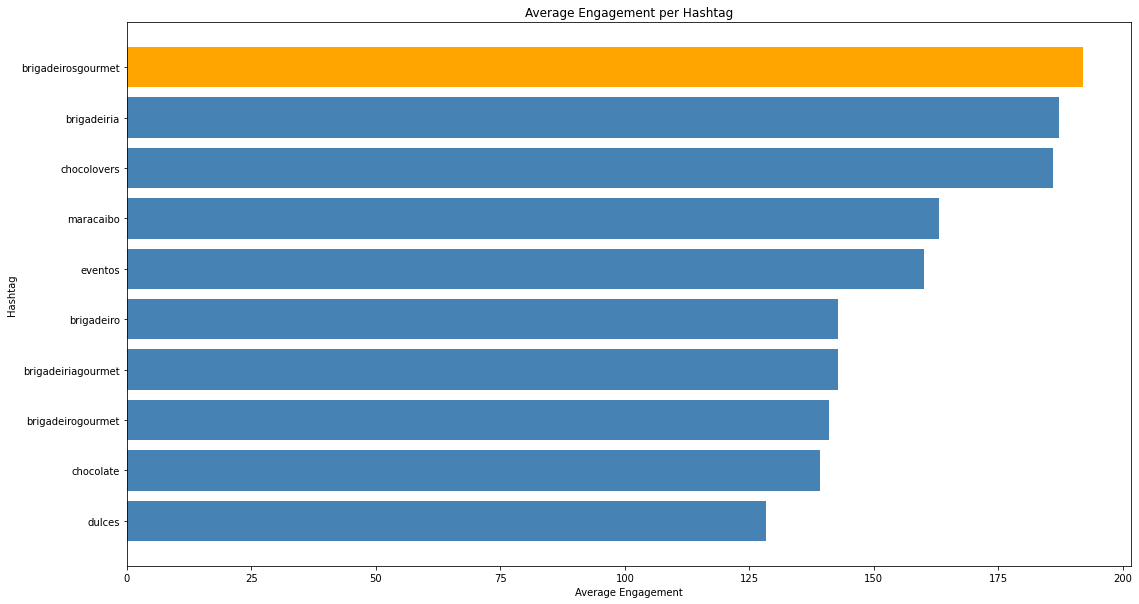

In [40]:
df_hashtags = df_hashtags.sort_values(by='average_engagement', ascending=True)
max_index = df_hashtags['average_engagement'].idxmax()
# Set the color for each bar, highlighting the highest bar with a different color
colors = ['steelblue' if i != max_index else 'orange' for i in df_hashtags.index]


# create a bar chart of the average engagements per hashtag
plt.figure(figsize=(18, 10))
plt.barh(df_hashtags['hashtag'], df_hashtags['average_engagement'], color = colors)
plt.xlabel('Average Engagement')
plt.ylabel('Hashtag')
plt.title('Average Engagement per Hashtag')
plt.show()

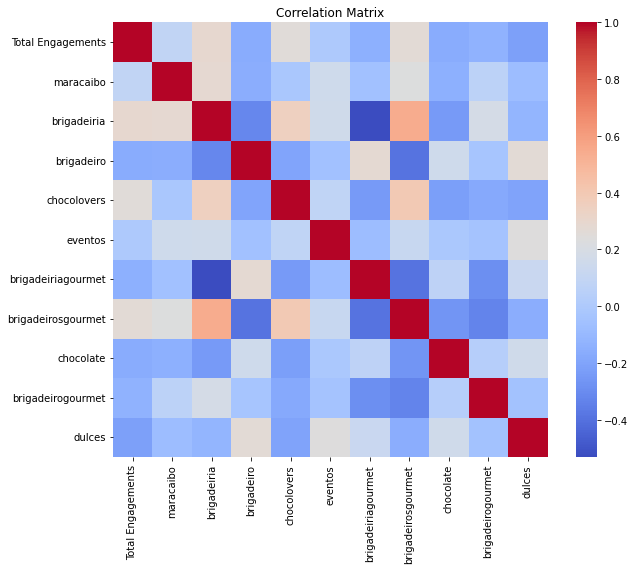

In [44]:
# Compute the correlation matrix
correlation_matrix = granulado_with_top10_hashtags.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

> #brigadeiro , #brigadeiro and #chocolovers are resulting in the highest average engagement

> Granulado should use these hashtags more often

## Post with the highest total engagements

In [44]:
# Find the index of the post with the highest total engagements
highest_engagements_index = granulado_with_top10_hashtags['Total Engagements'].idxmax()

# Retrieve the row with the highest total engagements
post_with_highest_engagements = granulado_with_top10_hashtags.loc[highest_engagements_index]

# Print the post with the highest total engagements
print(post_with_highest_engagements)

Total Engagements     625.0
maracaibo               1.0
brigadeiria             0.0
chocolovers             0.0
brigadeiro              1.0
eventos                 0.0
brigadeiriagourmet      0.0
brigadeirosgourmet      0.0
chocolate               0.0
brigadeirogourmet       0.0
dulces                  0.0
Name: 101, dtype: float64


# Caption Analysis

In [45]:
accounts = [granulado, delisweets, brigadeiro]
profile_info = pd.DataFrame()
for account in accounts:
    # Extract the relevant account information
    account_data = {
        'username': account['username'],
        'website': account['website'],
        'name': account['name'],
        'ig_id': account['ig_id'],
        'id': account['id'],
        'profile_picture_url': account['profile_picture_url'],
        'biography': account['biography'],
        'follows_count': account['follows_count'],
        'followers_count': account['followers_count'],
        'media_count': account['media_count']
    }
    # Append the account information to the dataframe
    profile_info = profile_info.append(account_data, ignore_index=True)
    
# Display the profile information of every account
profile_info

,username,website,name,ig_id,id,profile_picture_url,biography,follows_count,followers_count,media_count
0,granulado_mcbo,http://wa.me/584246416641,By Hanan,38415715533,17841438505991964,https://scontent.fbey5-2.fna.fbcdn.net/v/t51.2...,Los mejores Brigadeiros Gourmet de la ciudad ❣...,384,4492,236
1,delisweets_mcbo,https://wa.me/+584146024444,Delisweets_mcbo,5329539481,17841405384436192,https://scontent.fbey5-1.fna.fbcdn.net/v/t51.2...,"""єи∂υℓzαи∂σ тυѕ мσмєитσѕ єѕρєςιαℓєѕ""\n Rᴇᴘᴏs...",3651,11591,1539
2,brigadeirobombon,https://wa.me/17867275707,BrigadeiroBombón,7519403786,17841407553589925,https://scontent.fbey5-2.fna.fbcdn.net/v/t51.2...,#brigadeirobombon,1335,2448,16


In [46]:
# transform the posts info of each JSON account to a dataframe
granulado_media = pd.json_normalize(granulado['media'])
delisweets_media = pd.json_normalize(delisweets['media'])
brigadeiro_media = pd.json_normalize(brigadeiro['media'])

In [47]:
granulado_media['caption']

0      Best Mom 🌸\n\nQue mejor manera de sorprender a...
1      Que tal esta Cajita de bombones de fresa para ...
2      Para ti Mamá 🌸\n\nTe presentamos nuestra cajit...
3      Feliz día del trabajador a toda aquella person...
4      Jueves de #tbt🔙📸 \n\nDe las cosas que más amo ...
                             ...                        
231    CHURROS, brigadeiro de chocolate blanco envuel...
232    Brigadeiro de coco tostado, para los amantes d...
233    Brigadeiro napolitano envuelto en azúcar, una ...
234    Brigadeiro tradicional de chocolate envuelto c...
235    Hello everybody 😻🙈, mi nombre es Hanan y quier...
Name: caption, Length: 236, dtype: object

## Data Processing 

### Regular expressions

In [48]:
# to change and test with other regular expressions
# Convert text to lowercase
granulado_media['processed_caption'] = granulado_media['caption'].str.lower()

# Remove mentions (@username) because they want affect sentiment analysis
granulado_media['processed_caption'] = granulado_media['processed_caption'].str.replace("@[A-Za-z0-9_]+","", regex=True)

# Remove hashtags (#hashtag) because they want affect sentiment analysis
granulado_media['processed_caption'] = granulado_media['processed_caption'].str.replace("#[A-Za-z0-9_]+","", regex=True)

In [49]:
# Remove all special characers except '!'
granulado_media['processed_caption'] = granulado_media['processed_caption'].str.replace('[^\w\s!]', ' ', regex=True)

# Remove extra white space
granulado_media['processed_caption'] = granulado_media['processed_caption'].str.replace('\s+', ' ', regex=True)

# Remove digits because they want affect the sentiment analysis
granulado_media['processed_caption'] = granulado_media['processed_caption'].str.replace('\d+', '', regex=True)

granulado_media['processed_caption'].head()

0    best mom que mejor manera de sorprender a mamá...
1    que tal esta cajita de bombones de fresa para ...
2    para ti mamá te presentamos nuestra cajita par...
3    feliz día del trabajador a toda aquella person...
4    jueves de de las cosas que más amo y disfruto ...
Name: processed_caption, dtype: object

### Stemmer

In [50]:
# Initialize the stemmer
stemmer = SnowballStemmer('spanish')

# Define a function to stemmatize the text
def stemmatize_text(text):
    # Split the text into words
    words = text.split()
    # Stemmatize each word and join them back into a string
    return ' '.join([stemmer.stem(word) for word in words])

# Apply the stemmatize_text function to the 'caption' column in your dataframe
granulado_media['processed_caption'] = granulado_media['processed_caption'].apply(stemmatize_text)

In [51]:
granulado_media['processed_caption']

0      best mom que mejor maner de sorprend a mam que...
1      que tal esta cajit de bombon de fres par mam e...
2      par ti mam te present nuestr cajit par la pers...
3      feliz dia del trabaj a tod aquell person perse...
4      juev de de las cos que mas amo y disfrut en mi...
                             ...                        
231    churr brigadeir de chocolat blanc envuelt en a...
232           brigadeir de coc tost par los amant de coc
233    brigadeir napolitan envuelt en azuc una ric co...
234    brigadeir tradicional de chocolat envuelt con ...
235    hell everybody mi nombr es han y quier darl la...
Name: processed_caption, Length: 236, dtype: object

### Frequency-Based Filtering

In [52]:
# Define a function to remove stop words from a sentence
def remove_stop_words(sentence):
    # Get the set of stop words in Spanish
    stop_words = set(stopwords.words('spanish'))
    # Split the sentence into individual words
    words = sentence.split()
    # Filter out the stop words from the list of words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Join the filtered words back into a sentence and return it
    return ' '.join(filtered_words)


# Apply the remove_stop_words function to the 'text' column of the 'df1' DataFrame
granulado_media['processed_caption'] = granulado_media['processed_caption'].apply(remove_stop_words)

In [53]:
granulado_media.head()

,id,caption,like_count,comments_count,timestamp,username,media_product_type,media_type,permalink,comments,owner.id,media_url,children,processed_caption
0,18017482780562598,Best Mom 🌸\n\nQue mejor manera de sorprender a...,22.0,5,2023-05-12T17:38:18+0000,granulado_mcbo,REELS,VIDEO,https://www.instagram.com/reel/CsJtXdQukIH/,"[{'likes': 0, 'text': 'Perfecto 👌🏻😍', 'timesta...",17841438505991964,NaN,NaN,best mom mejor maner sorprend mam nuestr caj b...
1,18220938805169168,Que tal esta Cajita de bombones de fresa para ...,NaN,2,2023-05-08T22:31:32+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr_79juuGr4/,"[{'likes': 0, 'text': '😍😍😍', 'timestamp': '202...",17841438505991964,https://scontent.cdninstagram.com/v/t51.29350-...,[{'media_url': 'https://scontent.cdninstagram....,tal cajit bombon fres par mam merec much mas c...
2,18246243514080315,Para ti Mamá 🌸\n\nTe presentamos nuestra cajit...,NaN,3,2023-05-05T23:26:28+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/Cr4T3X9u9r1/,"[{'likes': 0, 'text': '😍😍😍', 'timestamp': '202...",17841438505991964,https://scontent.cdninstagram.com/v/t51.29350-...,[{'media_url': 'https://scontent.cdninstagram....,par mam present nuestr cajit par person mas im...
3,17979645017171644,Feliz día del trabajador a toda aquella person...,145.0,24,2023-05-01T16:47:31+0000,granulado_mcbo,REELS,VIDEO,https://www.instagram.com/reel/CrtS_1csuns/,"[{'likes': 0, 'text': '❤️❤️❤️❤️', 'timestamp':...",17841438505991964,https://scontent.cdninstagram.com/o1/v/t16/f1/...,NaN,feliz dia trabaj tod aquell person persever tr...
4,17975176586329879,Jueves de #tbt🔙📸 \n\nDe las cosas que más amo ...,84.0,9,2023-04-27T23:33:05+0000,granulado_mcbo,FEED,CAROUSEL_ALBUM,https://www.instagram.com/p/CrjuQvruMk3/,"[{'likes': 0, 'text': '👏❤️', 'timestamp': '202...",17841438505991964,https://scontent.cdninstagram.com/v/t51.29350-...,[{'media_url': 'https://scontent.cdninstagram....,juev cos mas amo disfrut trabaj personaliz bom...


## Feature Engineering

In [54]:
new = granulado_media[['processed_caption','like_count']]

In [55]:
# Create an instance of the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the processed text data
vectorizer.fit(new['processed_caption'])

# Transform the processed text data into vectors
text_vectors = vectorizer.transform(new['processed_caption'])

In [56]:
# Create an instance of the TfidfVectorizer with n-gram range
ngram_range = (1, 2)  
vectorizer = TfidfVectorizer(ngram_range=ngram_range)

# Fit the vectorizer on the processed text data
vectorizer.fit(new['processed_caption'])

# Transform the processed text data into vectors
text_vectors = vectorizer.transform(new['processed_caption'])

In [57]:
# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Convert text_vectors to a dataframe with column names
text_vectors_df = pd.DataFrame(text_vectors.toarray(), columns=feature_names)

# Add the like_count column from the 'new' dataframe
text_vectors_df['like_count'] = new['like_count']

In [58]:
text_vectors_df.head()

,aba,aba hac,abiert,abiert escriben,abiert par,abri,abri cuent,abri puert,aburr,aburr signif,...,𝒲𝒾𝓉𝒽 𝒱𝑒,𝙎𝙖𝙮,𝙎𝙖𝙮 𝙞𝙩,𝙘𝙝𝙤𝙘𝙤𝙡𝙖𝙩𝙚,𝙘𝙝𝙤𝙘𝙤𝙡𝙖𝙩𝙚 dil,𝙞𝙩,𝙞𝙩 𝙬𝙞𝙩𝙝,𝙬𝙞𝙩𝙝,𝙬𝙞𝙩𝙝 𝙘𝙝𝙤𝙘𝙤𝙡𝙖𝙩𝙚,like_count
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.115783,0.0,0.121985,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0


## Analysis

In [59]:
# Sum the values for each column except 'like_count'
column_sums = text_vectors_df.drop('like_count', axis=1).sum()

# Select the top 30 columns with the highest values
top_30_columns = column_sums.nlargest(30)

# Display the top 10 columns
print(top_30_columns)

par              11.210181
nuestr            8.177666
brigadeir         7.557110
chocolat          6.333171
sabor             6.307352
bombon            5.885790
mas               5.747385
delici            5.400036
much              4.434482
fres              4.283224
perfect           4.230302
tod               4.223105
exquisit          4.177117
priv              4.112501
prob              3.870578
dulc              3.865174
cajit             3.743875
escriben          3.706240
hac               3.566056
hermos            3.529955
especial          3.525125
detall            3.505681
llen              3.464258
present           3.454740
com               3.440017
dia               3.410357
gust              3.393705
amor              3.297173
escriben priv     3.294161
perfect par       3.292014
dtype: float64


In [60]:
# Get the names of the top 30 columns
top_10_columns_names = top_30_columns.index.tolist()


# Select only the columns mentioned in top_10_columns
selected_columns = text_vectors_df[top_10_columns_names]

# Assign the selected columns back to the dataframe
text_vectors_df = selected_columns

In [61]:
# Add the like_count column from the 'new' dataframe
text_vectors_df['like_count'] = new['like_count']

In [62]:
text_vectors_df.head()

,par,nuestr,brigadeir,chocolat,sabor,bombon,mas,delici,much,fres,...,detall,llen,present,com,dia,gust,amor,escriben priv,perfect par,like_count
0,0.056897,0.074553,0.0,0.0,0.00000,0.094543,0.00000,0.0,0.000000,0.108226,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,22.0
1,0.062034,0.000000,0.0,0.0,0.00000,0.103080,0.09778,0.0,0.111588,0.117998,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,NaN
2,0.155563,0.101918,0.0,0.0,0.05696,0.000000,0.06130,0.0,0.000000,0.000000,...,0.0,0.079417,0.076563,0.000000,0.085246,0.00000,0.0,0.0,0.0,NaN
3,0.033361,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.292497,0.00000,0.0,0.0,0.0,145.0
4,0.000000,0.000000,0.0,0.0,0.00000,0.063432,0.06017,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.075152,0.000000,0.08026,0.0,0.0,0.0,84.0


In [63]:
column_names = text_vectors_df.columns.tolist()
print(column_names)

['par', 'nuestr', 'brigadeir', 'chocolat', 'sabor', 'bombon', 'mas', 'delici', 'much', 'fres', 'perfect', 'tod', 'exquisit', 'priv', 'prob', 'dulc', 'cajit', 'escriben', 'hac', 'hermos', 'especial', 'detall', 'llen', 'present', 'com', 'dia', 'gust', 'amor', 'escriben priv', 'perfect par', 'like_count']


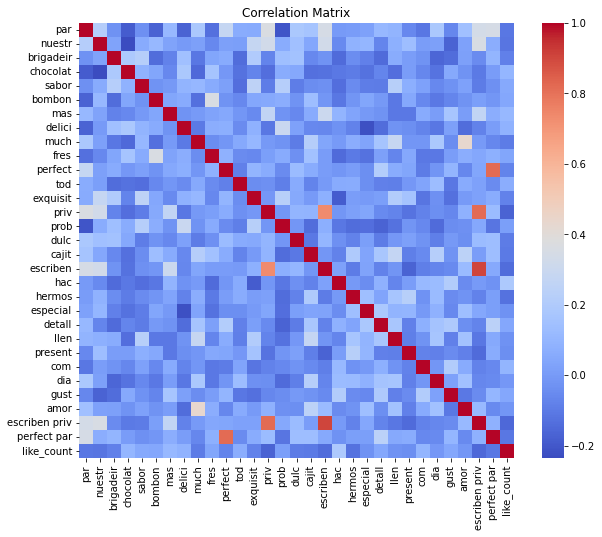

In [64]:
# Compute the correlation matrix
correlation_matrix = text_vectors_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

Based on the correlation matrix, we can identify a list of top words that have high correlation with the like count. they have a correlation 0.4 - 0.5:  
  
'sabor', 'chocolat', 'bombon', 'mas', 'delici', 'fres', 'tod', 'com', 'gust'

Here are the meanings of the words:

- sabor: verb that means taste (e.g. tastes great)
- chocolate: chocolate
- bombón: candy, bonbon
- más: more
- delicioso: delicious
- fresco: fresh
- todo: everything, all
- comer: to eat with pleasure
- gusto: taste, pleasure

In [65]:
columns_to_keep = ['sabor', 'chocolat', 'bombon', 'mas', 'delici', 'fres', 'tod', 'com', 'gust']
text_vectors_df = text_vectors_df.loc[:, columns_to_keep]

In [66]:
new_column_names = ['sabor', 'chocolate', 'bombón', 'más', 'delicioso', 'fresco', 'todo', 'comer', 'gusto']
text_vectors_df = text_vectors_df.rename(columns=dict(zip(text_vectors_df.columns, new_column_names)))

In [67]:
# Add the like_count column from the 'new' dataframe
text_vectors_df['like_count'] = new['like_count']
text_vectors_df

,sabor,chocolate,bombón,más,delicioso,fresco,todo,comer,gusto,like_count
0,0.000000,0.000000,0.094543,0.00000,0.0,0.108226,0.000000,0.000000,0.00000,22.0
1,0.000000,0.000000,0.103080,0.09778,0.0,0.117998,0.000000,0.000000,0.00000,NaN
2,0.056960,0.000000,0.000000,0.06130,0.0,0.000000,0.000000,0.000000,0.00000,NaN
3,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.120944,0.000000,0.00000,145.0
4,0.000000,0.000000,0.063432,0.06017,0.0,0.000000,0.000000,0.075152,0.08026,84.0
...,...,...,...,...,...,...,...,...,...,...
231,0.000000,0.111200,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,55.0
232,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,52.0
233,0.095529,0.103470,0.000000,0.00000,0.0,0.124067,0.000000,0.000000,0.00000,54.0
234,0.000000,0.275234,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,55.0
